In [5]:
import pandas as pd
import numpy as np
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, Subset, ConcatDataset, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import models
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
base_dir = "data/FloodNet Challenge - Track 1"

In [7]:
class FloodNetImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)

In [8]:
# Define data augmentations and preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [9]:
# Split the labeled training data into training and validation sets. The validation set will be used
# for final evaluation of the model
train_dir = f'{base_dir}/Train/Labeled'

image_paths = []
labels = []
class_to_idx = {'Flooded': 0, 'Non-Flooded':1}

for class_name in ['Flooded', 'Non-Flooded']:
    image_dir = os.path.join(train_dir, class_name, 'image')
    if not os.path.exists(image_dir):
        continue

    for fname in os.listdir(image_dir):
        if fname.lower().endswith(('.jpg', '.png')):
            image_paths.append(os.path.join(image_dir, fname))
            labels.append(class_to_idx[class_name])

# Perform 80-20 stratified split with paths and labels
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print("Number of training samples: ", len(train_labels))
print("Number of validation samples: ", len(val_labels))

Number of training samples:  318
Number of validation samples:  80


In [10]:
# Count label occurrences
label_counts = Counter(train_labels)

# Print class distribution by label index
print("Train Label Distribution:")
for label_idx, count in sorted(label_counts.items()):
    print(f"Label {label_idx}: {count}")

Train Label Distribution:
Label 0: 41
Label 1: 277


In [11]:
# Create the training and validation datasets
train_dataset = FloodNetImageDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = FloodNetImageDataset(val_paths, val_labels, transform=val_transforms)

In [12]:
# Large class imbalance so need to use WeightedRandomSampler to ensure balanced mini-batches
# during training.

# Extract the training labels from the dataset
targets = [label for _, label in train_dataset]

# Calculate class weights, which are the inverse of class frequencies. Classes with fewer samples will get assigned a higher 
# weight (ensuring that the minority class receives a higher weight, making it more likely to be sampled during training).
class_counts = np.bincount(targets)  # Count the number of samples per class
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

# Assign a weight to each sample
sample_weights = torch.tensor([class_weights[label] for label in targets], dtype=torch.float)

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [13]:
# Import the ViT model for transfer learning
model = models.vit_b_16(weights=ViT_B_16_Weights.DEFAULT )
# Freeze the parameters in the base model so only the new layers are being updated
for param in model.parameters():
    param.requires_grad = False

num_classes = len(class_counts)
# Replace the final layer with a FC layer
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

# Unfreeze the final layer to allow it to learn during training
for param in model.heads.head.parameters():
    param.requires_grad = True

model = model.to(device)

In [14]:
# Define learning rate scheduler with warmup period
def get_linear_warmup_scheduler(optimizer, base_lr, num_epochs, num_warmup=3):
    def lr_lambda(epoch):
        return min(1.0, (epoch+1) / num_warmup)

    return lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Halve learning rate if loss doesn't improve after 3 epochs
def get_plateau_scheduler(optimizer):
    return lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5, # halve the loss
        threshold=1e-4,
        patience=3) # apply after 3 epochs of non-improving loss

In [15]:
# Initialize the loss function with the class weights to penalize errors made on the minority class more heavily.
criterion = nn.CrossEntropyLoss(weight=class_weights)
batch_size = 32
learning_rate = 0.001
weight_decay = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
num_epochs = 20
warmup_epochs = 3
warmup_scheduler = get_linear_warmup_scheduler(optimizer, learning_rate, num_epochs, warmup_epochs)
plateau_scheduler = get_plateau_scheduler(optimizer)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [16]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device, 
                is_initial=True, val_loader=None):
    best_f1 = -1.0
    best_val_f1 = -1.0
    best_confidence = -float('inf')
    all_training_f1 = [] # Store the F1 scores per training epoch
    all_validation_f1 = [] # Store the validation F1 scores per training epoch
    all_confidences = [] # Store the average confidence for the retrained model
    save_path = "best_initial_model.pth" if is_initial else "best_retrained_model.pth"
        
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_labels = []
        
        for batch in train_loader:
            images, labels = batch        
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Track predictions and labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        train_f1 = f1_score(all_labels, all_preds, average='macro')
        all_training_f1.append(train_f1)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
        
        # Check if validation should be used for model saving
        if not is_initial and val_loader is not None:
            # Validation step
            model.eval()
            
            with torch.no_grad():
                all_val_preds = []
                all_val_labels = []
                total_confidence = 0.0

                for val_images, val_labels in val_loader:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    
                    val_outputs = model(val_images)
                    probabilities = torch.softmax(val_outputs, dim=1)
                    confidences, preds = torch.max(probabilities, dim=1)

                    total_confidence += confidences.sum().item()
                    all_val_preds.extend(preds.cpu().numpy())
                    all_val_labels.extend(val_labels.cpu().numpy())
            
            avg_confidence = total_confidence / len(val_loader.dataset)
            all_confidences.append(avg_confidence)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')
            all_validation_f1.append(val_f1)
            val_acc = (np.array(all_val_preds) == np.array(all_val_labels)).mean()
            print(f"Validation Accuracy: {val_acc:.4f} | F1 Score: {val_f1:.4f} | Average Confidence: {avg_confidence:.4f}")

            # Save the best retrained model based on confidence
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                torch.save(model.state_dict(), save_path)
                print(f"Model saved with val F1 score: {best_val_f1:.4f}")
        
        else:
            # Save the best model based on training F1 score (due to large class imbalance)
            if train_f1 > best_f1:
                best_f1 = train_f1
                torch.save(model.state_dict(), save_path)
                print(f"New best model saved with training F1 score: {best_f1:.4f}")

        # Step the scheduler at the end of each epoch
        if warmup_scheduler and epoch < warmup_epochs:
            warmup_scheduler.step()
        elif plateau_scheduler and not is_initial and val_loader is not None:
            plateau_scheduler.step(-avg_confidence)  # Use negative confidence to minimize
        elif plateau_scheduler:
            plateau_scheduler.step(train_f1)  # Fallback if val not used
    
    return model, all_training_f1, all_confidences, all_validation_f1

In [17]:
trained_model, training_f1_scores, _, _ = train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    is_initial=True,
)

Epoch [1/20] | Loss: 0.7630 | Acc: 0.5472 | Train F1: 0.5419
New best model saved with training F1 score: 0.5419
Epoch [2/20] | Loss: 0.3450 | Acc: 0.5377 | Train F1: 0.4077
Epoch [3/20] | Loss: 0.2749 | Acc: 0.5283 | Train F1: 0.3630
Epoch [4/20] | Loss: 0.2625 | Acc: 0.5283 | Train F1: 0.4371
Epoch [5/20] | Loss: 0.2213 | Acc: 0.7390 | Train F1: 0.7253
New best model saved with training F1 score: 0.7253
Epoch [6/20] | Loss: 0.1676 | Acc: 0.8145 | Train F1: 0.8110
New best model saved with training F1 score: 0.8110
Epoch [7/20] | Loss: 0.1591 | Acc: 0.8428 | Train F1: 0.8388
New best model saved with training F1 score: 0.8388
Epoch [8/20] | Loss: 0.1208 | Acc: 0.8711 | Train F1: 0.8658
New best model saved with training F1 score: 0.8658
Epoch [9/20] | Loss: 0.1337 | Acc: 0.8522 | Train F1: 0.8520
Epoch [10/20] | Loss: 0.1260 | Acc: 0.8774 | Train F1: 0.8765
New best model saved with training F1 score: 0.8765
Epoch [11/20] | Loss: 0.1102 | Acc: 0.9245 | Train F1: 0.9228
New best model 

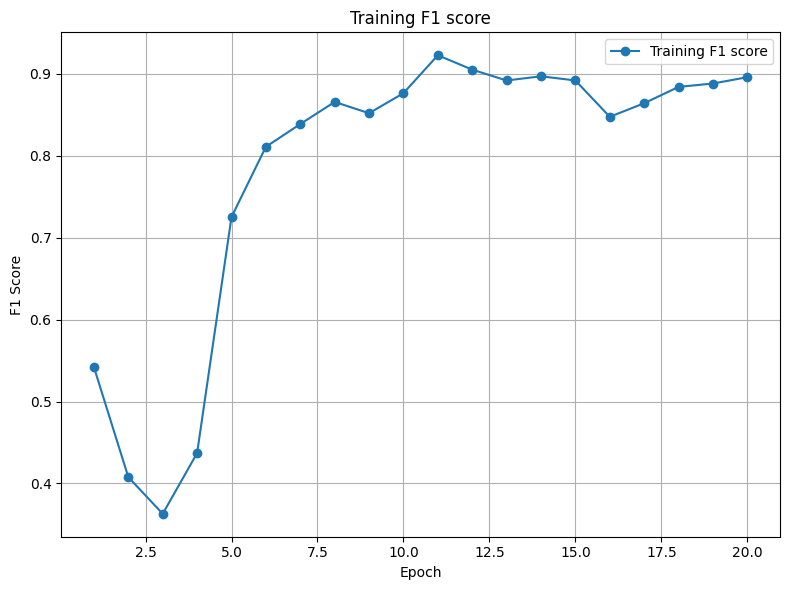

In [18]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(training_f1_scores) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_f1_scores, label='Training F1 score', marker='o')
plt.title('Training F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Need another class for unlabeled data with different folder structure
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.png', '.jpg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image  # No label available

In [20]:
def generate_pseudo_labels(trained_model, unlabeled_train_dataset, batch_size, confidence_threshold=0.9):
    # Path to the best performing initial model
    model_path = os.path.join(".", "best_initial_model.pth")
    trained_model.load_state_dict(torch.load(model_path, weights_only=True))
    
    # DataLoader for unlabeled data
    unlabeled_loader = DataLoader(unlabeled_train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    print(f"Number of unlabeled samples: {len(unlabeled_loader.dataset)}")
    pseudo_labeled_data = []
    
    with torch.no_grad():
        for images in unlabeled_loader:
            images = images.to(device)
            outputs = trained_model(images)
            probabilities = F.softmax(outputs, dim=1)  # Get class probabilities
            confidences, pseudo_labels = torch.max(probabilities, dim=1)  # Max confidence and corresponding class
    
            # Save the highest confidence outputs
            for i in range(len(images)):
                if confidences[i] > confidence_threshold:
                    img_tensor = images[i].cpu()
                    label_tensor = pseudo_labels[i].cpu().to(dtype=torch.long)
                    pseudo_labeled_data.append((img_tensor, label_tensor))
    
    print(f"Pseudo-labeled {len(pseudo_labeled_data)} images from the unlabeled dataset.")

    return pseudo_labeled_data

In [21]:
# Load the unlabeled training data
unlabeled_train_dir = f'{base_dir}/Train/Unlabeled/image'

# Weak transforms for pseudo-labeling
pseudo_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])
unlabeled_train_dataset = UnlabeledImageDataset(unlabeled_train_dir, transform=pseudo_transform)

In [22]:
# Generate the pseudo labels for the unlabeled dataset
pseudo_labeled_data = generate_pseudo_labels(trained_model, unlabeled_train_dataset, batch_size)

Number of unlabeled samples: 281
Pseudo-labeled 24 images from the unlabeled dataset.


In [23]:
# Combine the original training dataset with the high confidence pseudo-labeled data
pseudo_images, pseudo_labels = zip(*pseudo_labeled_data)
pseudo_dataset = TensorDataset(torch.stack(pseudo_images), torch.stack(pseudo_labels))
combined_dataset = ConcatDataset([train_dataset, pseudo_dataset])

In [24]:
# Combine the targets from both datasets
all_targets = []

for i in range(len(combined_dataset)):
    _, label = combined_dataset[i]
    all_targets.append(label)
    
# Calculate class weights (inverse of class frequencies)
class_counts = np.bincount(all_targets)
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

# Assign weights to each sample in the augmented dataset
sample_weights = torch.tensor([class_weights[label] for label in all_targets], dtype=torch.float)

# Create the WeightedRandomSampler
augmented_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create the DataLoader
augmented_loader = DataLoader(combined_dataset, batch_size=batch_size, sampler=augmented_sampler, num_workers=4)

In [25]:
retrained_model, training_f1_scores, validation_confidence_scores, validation_f1_scores = train_model(
    model=trained_model,
    train_loader=augmented_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    is_initial=False,
    val_loader=val_loader
)

Epoch [1/20] | Loss: 0.1026 | Acc: 0.8772 | Train F1: 0.8765
Validation Accuracy: 0.7500 | F1 Score: 0.6549 | Average Confidence: 0.7775
Model saved with val F1 score: 0.6549
Epoch [2/20] | Loss: 0.1008 | Acc: 0.9444 | Train F1: 0.9443
Validation Accuracy: 0.7875 | F1 Score: 0.6891 | Average Confidence: 0.8002
Model saved with val F1 score: 0.6891
Epoch [3/20] | Loss: 0.0824 | Acc: 0.9298 | Train F1: 0.9295
Validation Accuracy: 0.7875 | F1 Score: 0.6891 | Average Confidence: 0.8066
Epoch [4/20] | Loss: 0.0942 | Acc: 0.9123 | Train F1: 0.9116
Validation Accuracy: 0.7875 | F1 Score: 0.6891 | Average Confidence: 0.8159
Epoch [5/20] | Loss: 0.0718 | Acc: 0.9444 | Train F1: 0.9436
Validation Accuracy: 0.7750 | F1 Score: 0.6774 | Average Confidence: 0.8210
Epoch [6/20] | Loss: 0.0809 | Acc: 0.9035 | Train F1: 0.9020
Validation Accuracy: 0.7750 | F1 Score: 0.6774 | Average Confidence: 0.8240
Epoch [7/20] | Loss: 0.0660 | Acc: 0.9474 | Train F1: 0.9469
Validation Accuracy: 0.8500 | F1 Score: 0

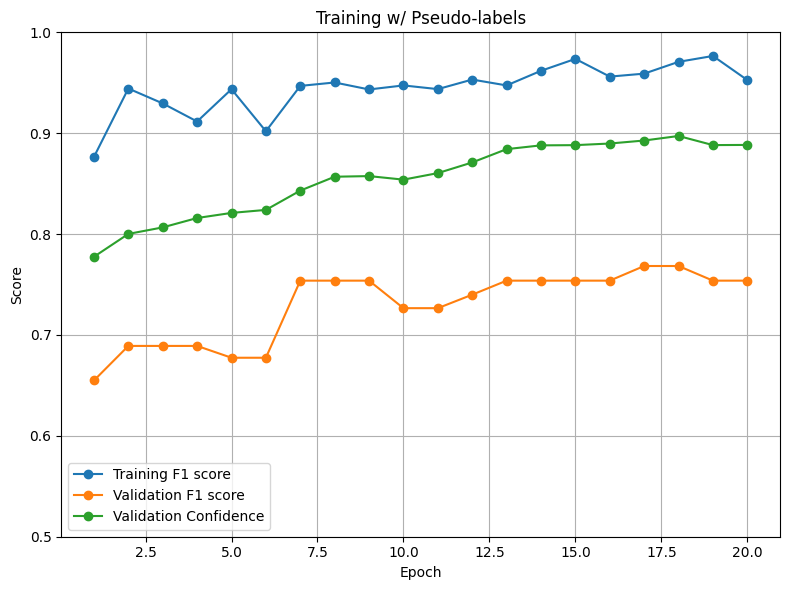

In [26]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(training_f1_scores) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_f1_scores, label='Training F1 score', marker='o')
plt.plot(epochs, validation_f1_scores, label='Validation F1 score', marker='o')
plt.plot(epochs, validation_confidence_scores, label='Validation Confidence', marker='o')
plt.title('Training w/ Pseudo-labels')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0.5, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()